In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import os, sys

In [3]:
from psychrochart import PsychroChart , load_config
import psychrolib as psylib
psylib.SetUnitSystem(psylib.SI)

from CoolProp.HumidAirProp import HAPropsSI

In [4]:
sys.path.insert(0, os.path.join('.','..','..','calibration'))
from thermodynamics import *

# import code of mathieu
import media_model_mgcl2 as model_mg
import media_model_water as model_w

In [5]:
# only reload the function imported by "aimport"
%autoreload 1
%aimport thermodynamics

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# read exp data

In [30]:
path_expdata = os.path.join(os.path.expanduser('~'), 'GIT', 'EnBA_M', 'BrineGrid_HDisNet', 'Extras', 'Python', 'exp_data')

In [31]:
df_ori = pd.read_excel(os.path.join(path_expdata, 'actual_data', 'dempav', 'dempav_2021_all.xlsx'), index_col=0)

In [32]:
df_ori.head()

,T_a_in,RH_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,RH_a_o_exp,x_a_o_exp,T_d_o_exp,epsilon_T,epsilon_w,epsilon_h,x_d_in_equ,RH_d_in_equ
0,295.299988,53.109997,0.008864,0.016580,307.058580,0.318301,0.102671,301.229980,55.309998,0.013235,NaN,0.504311,0.675941,0.602052,0.015330,45.801315
1,295.299988,57.220001,0.009560,0.015696,307.887747,0.318301,0.102671,301.229980,54.975215,0.013153,NaN,0.471092,0.550180,0.514231,0.016090,45.850585
2,297.619995,54.990002,0.010587,0.013828,300.367375,0.318451,0.102671,299.709991,52.950001,0.011560,NaN,0.760723,-3.095415,2.290839,0.010273,45.363621
3,295.619995,55.129997,0.009390,0.015091,298.757935,0.318318,0.102671,297.299988,52.639999,0.009932,NaN,0.535381,-7.333205,1.024653,0.009316,45.303721
4,295.805594,52.922000,0.009112,0.017080,301.561459,0.318328,0.102671,298.549988,48.299999,0.009818,NaN,0.476800,0.363564,0.424686,0.011053,45.467481


# try minimal

In [79]:
config_minimal = load_config('minimal')
#config_minimal

In [74]:
# plot 3 points
def plot_with_des_point_df(df_data, chart_template = 'ashrae', alpha = 0.6, ncol = 3, save_fig_name = False):
    
    # pre-configuration
    # Get a pre-configured style dict
    config_ashrae = load_config(chart_template)

    # customize configuration:
    config_ashrae['chart_params']['with_constant_wet_temp'] = False
    config_ashrae['chart_params']['constant_temp_label'] = None
    config_ashrae['chart_params']['constant_h_label'] = None
    config_ashrae['chart_params']['constant_v_label'] = None
    config_ashrae['chart_params']['constant_humid_label'] = None
    config_ashrae['chart_params']['constant_rh_label'] = None

    chart_customized_ashrae = PsychroChart(config_ashrae)
    # Plot the chart
    ax = chart_customized_ashrae.plot()
    
    points = {}
    connectors = []
    for i in df_data.index:
        
        # inlet
        air_in = 'air_in_{}'.format(i)
        T_air_in = df_data.loc[i, "T_a_in"]
        rh_air_in = df_data.loc[i, "RH_a_in"]        
        
        # outlet
        air_out = 'air_out_{}'.format(i)
        T_air_out = df_data.loc[i, "T_a_o_exp"]
        rh_air_out = df_data.loc[i, "RH_a_o_exp"]
        
        # des inlet
        des_in = 'des_in_{}'.format(i)
        T_des_in = df_data.loc[i, "T_d_in"]
        rh_des_in = df_data.loc[i, "RH_d_in_equ"]
        
        # color
        color = np.append(np.random.rand(3), alpha)
        print(color)
        
        # plot points
        point = {air_in: {'label': 'air_in_{}'.format(i),
                           'style': {'color': color,
                                     'marker': 'X', 'markersize': 15},
                           'xy': (T_air_in-273.15, rh_air_in)},
                  air_out: {
                      'label': 'air_out_{}'.format(i),
                      'style': {'color': color,
                                'marker': 'o', 'markersize': 10},
                      'xy': (T_air_out-273.15, rh_air_out)},
                 des_in: {
                     'label':'des_in_{}_equ'.format(i),
                     'style': {'color': color,
                                'marker': '+', 'markersize': 20},
                      'xy': (T_des_in-273.15, rh_des_in)}
                }
        
        # plot connectors
        # here the color CANNOT be specified by string e.g. red...
        connector = {'start': air_in,
                       'end': air_out,
                       'style': {'color': color,
                                 "linewidth": 2, "linestyle": "-."}}
        
        # add into dict and list
        points.update(point)
        connectors.append(connector)
        
    # add points and conncection to chart
    chart_customized_ashrae.plot_points_dbt_rh(points, connectors)

    # Add a legend
    chart_customized_ashrae.plot_legend(markerscale=1.2, frameon=False, fontsize=10, labelspacing=1.2, ncol = ncol)
    
    if save_fig_name:
        ax.get_figure().savefig(save_fig_name)
    
    return ax.get_figure()

[0.69692013 0.19175273 0.01338498 0.6       ]
[0.28798635 0.46101789 0.72321053 0.6       ]
[0.05932919 0.86251648 0.61010895 0.6       ]
[0.7082946  0.89321714 0.92735783 0.6       ]
[0.8943168  0.36322969 0.82011276 0.6       ]
[0.55063012 0.83291154 0.90991661 0.6       ]
[0.30570641 0.34282048 0.55002586 0.6       ]
[0.83063515 0.95407426 0.18837143 0.6       ]
[0.65771448 0.84965704 0.67218942 0.6       ]
[0.15552358 0.18915269 0.66288198 0.6       ]
[0.50067978 0.55354429 0.36766155 0.6       ]
[0.56469445 0.54388515 0.00089719 0.6       ]
[0.23103663 0.05116072 0.30443087 0.6       ]
[0.82499488 0.97177967 0.44077612 0.6       ]
[0.53983412 0.22470863 0.29459775 0.6       ]


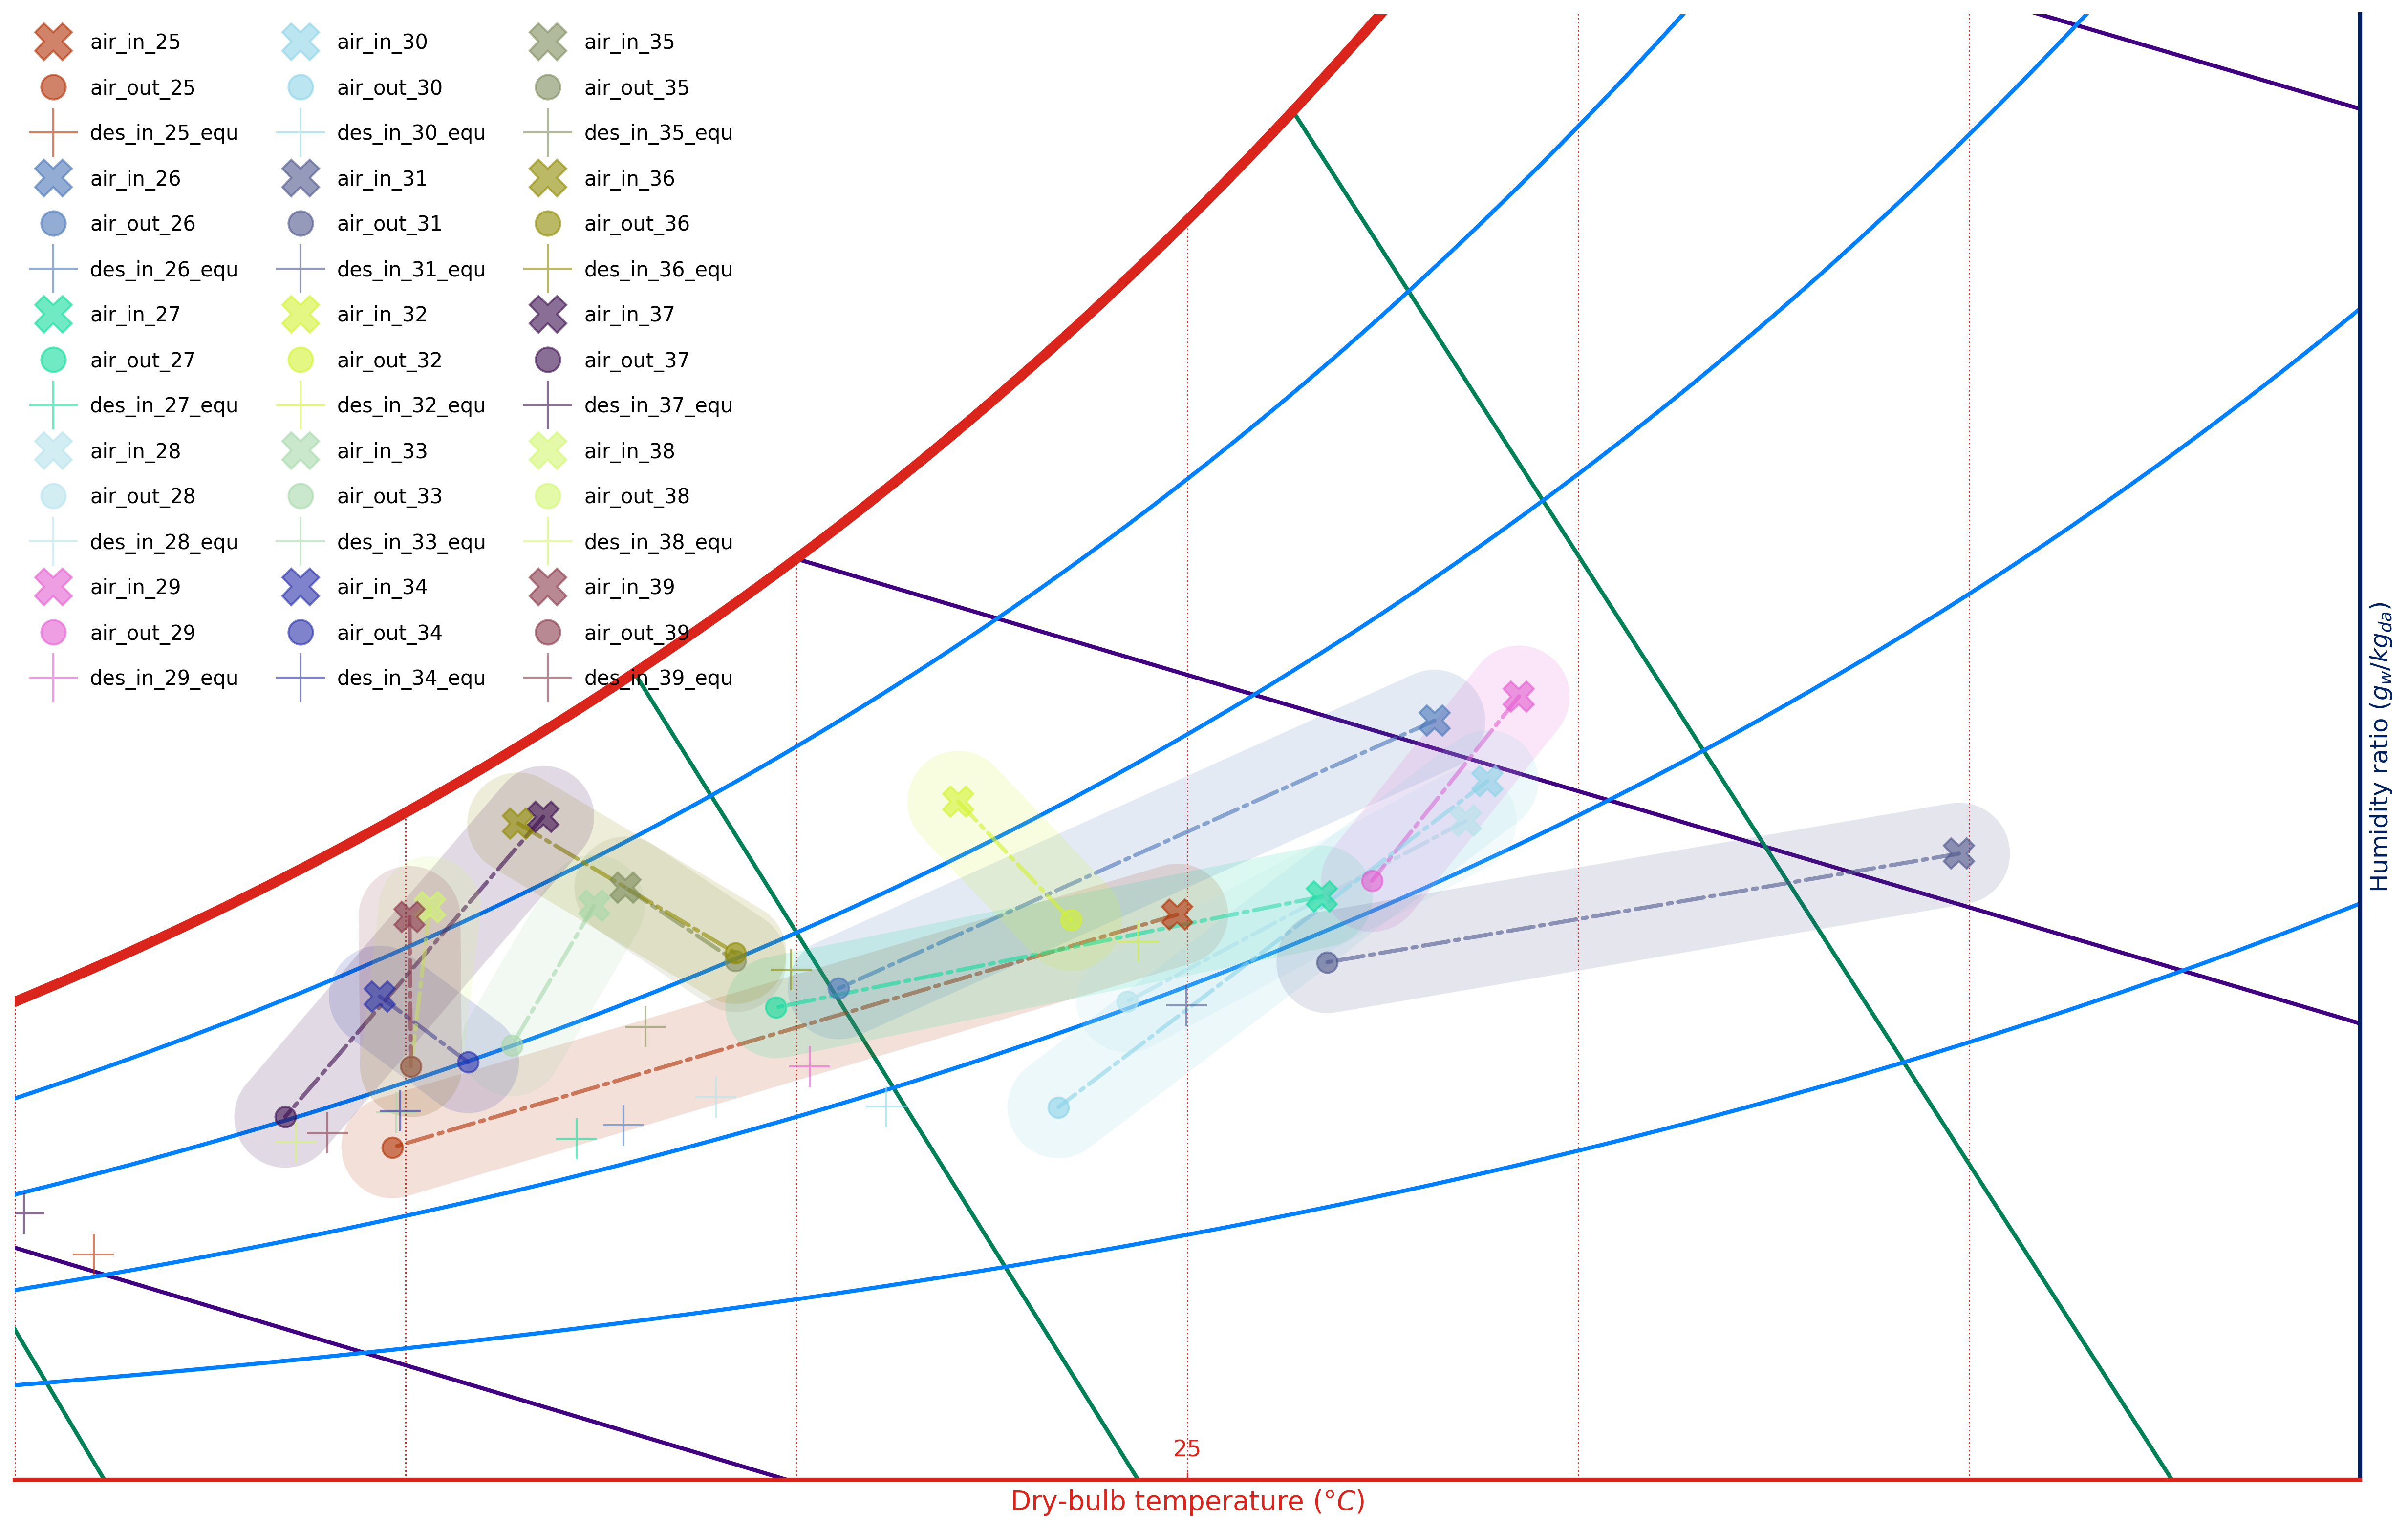

In [78]:
plot_with_des_point_df(df_data=df_ori.iloc[25:40,:], chart_template=config_minimal)

In [40]:
df_ori.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
           dtype='int64')

# Example

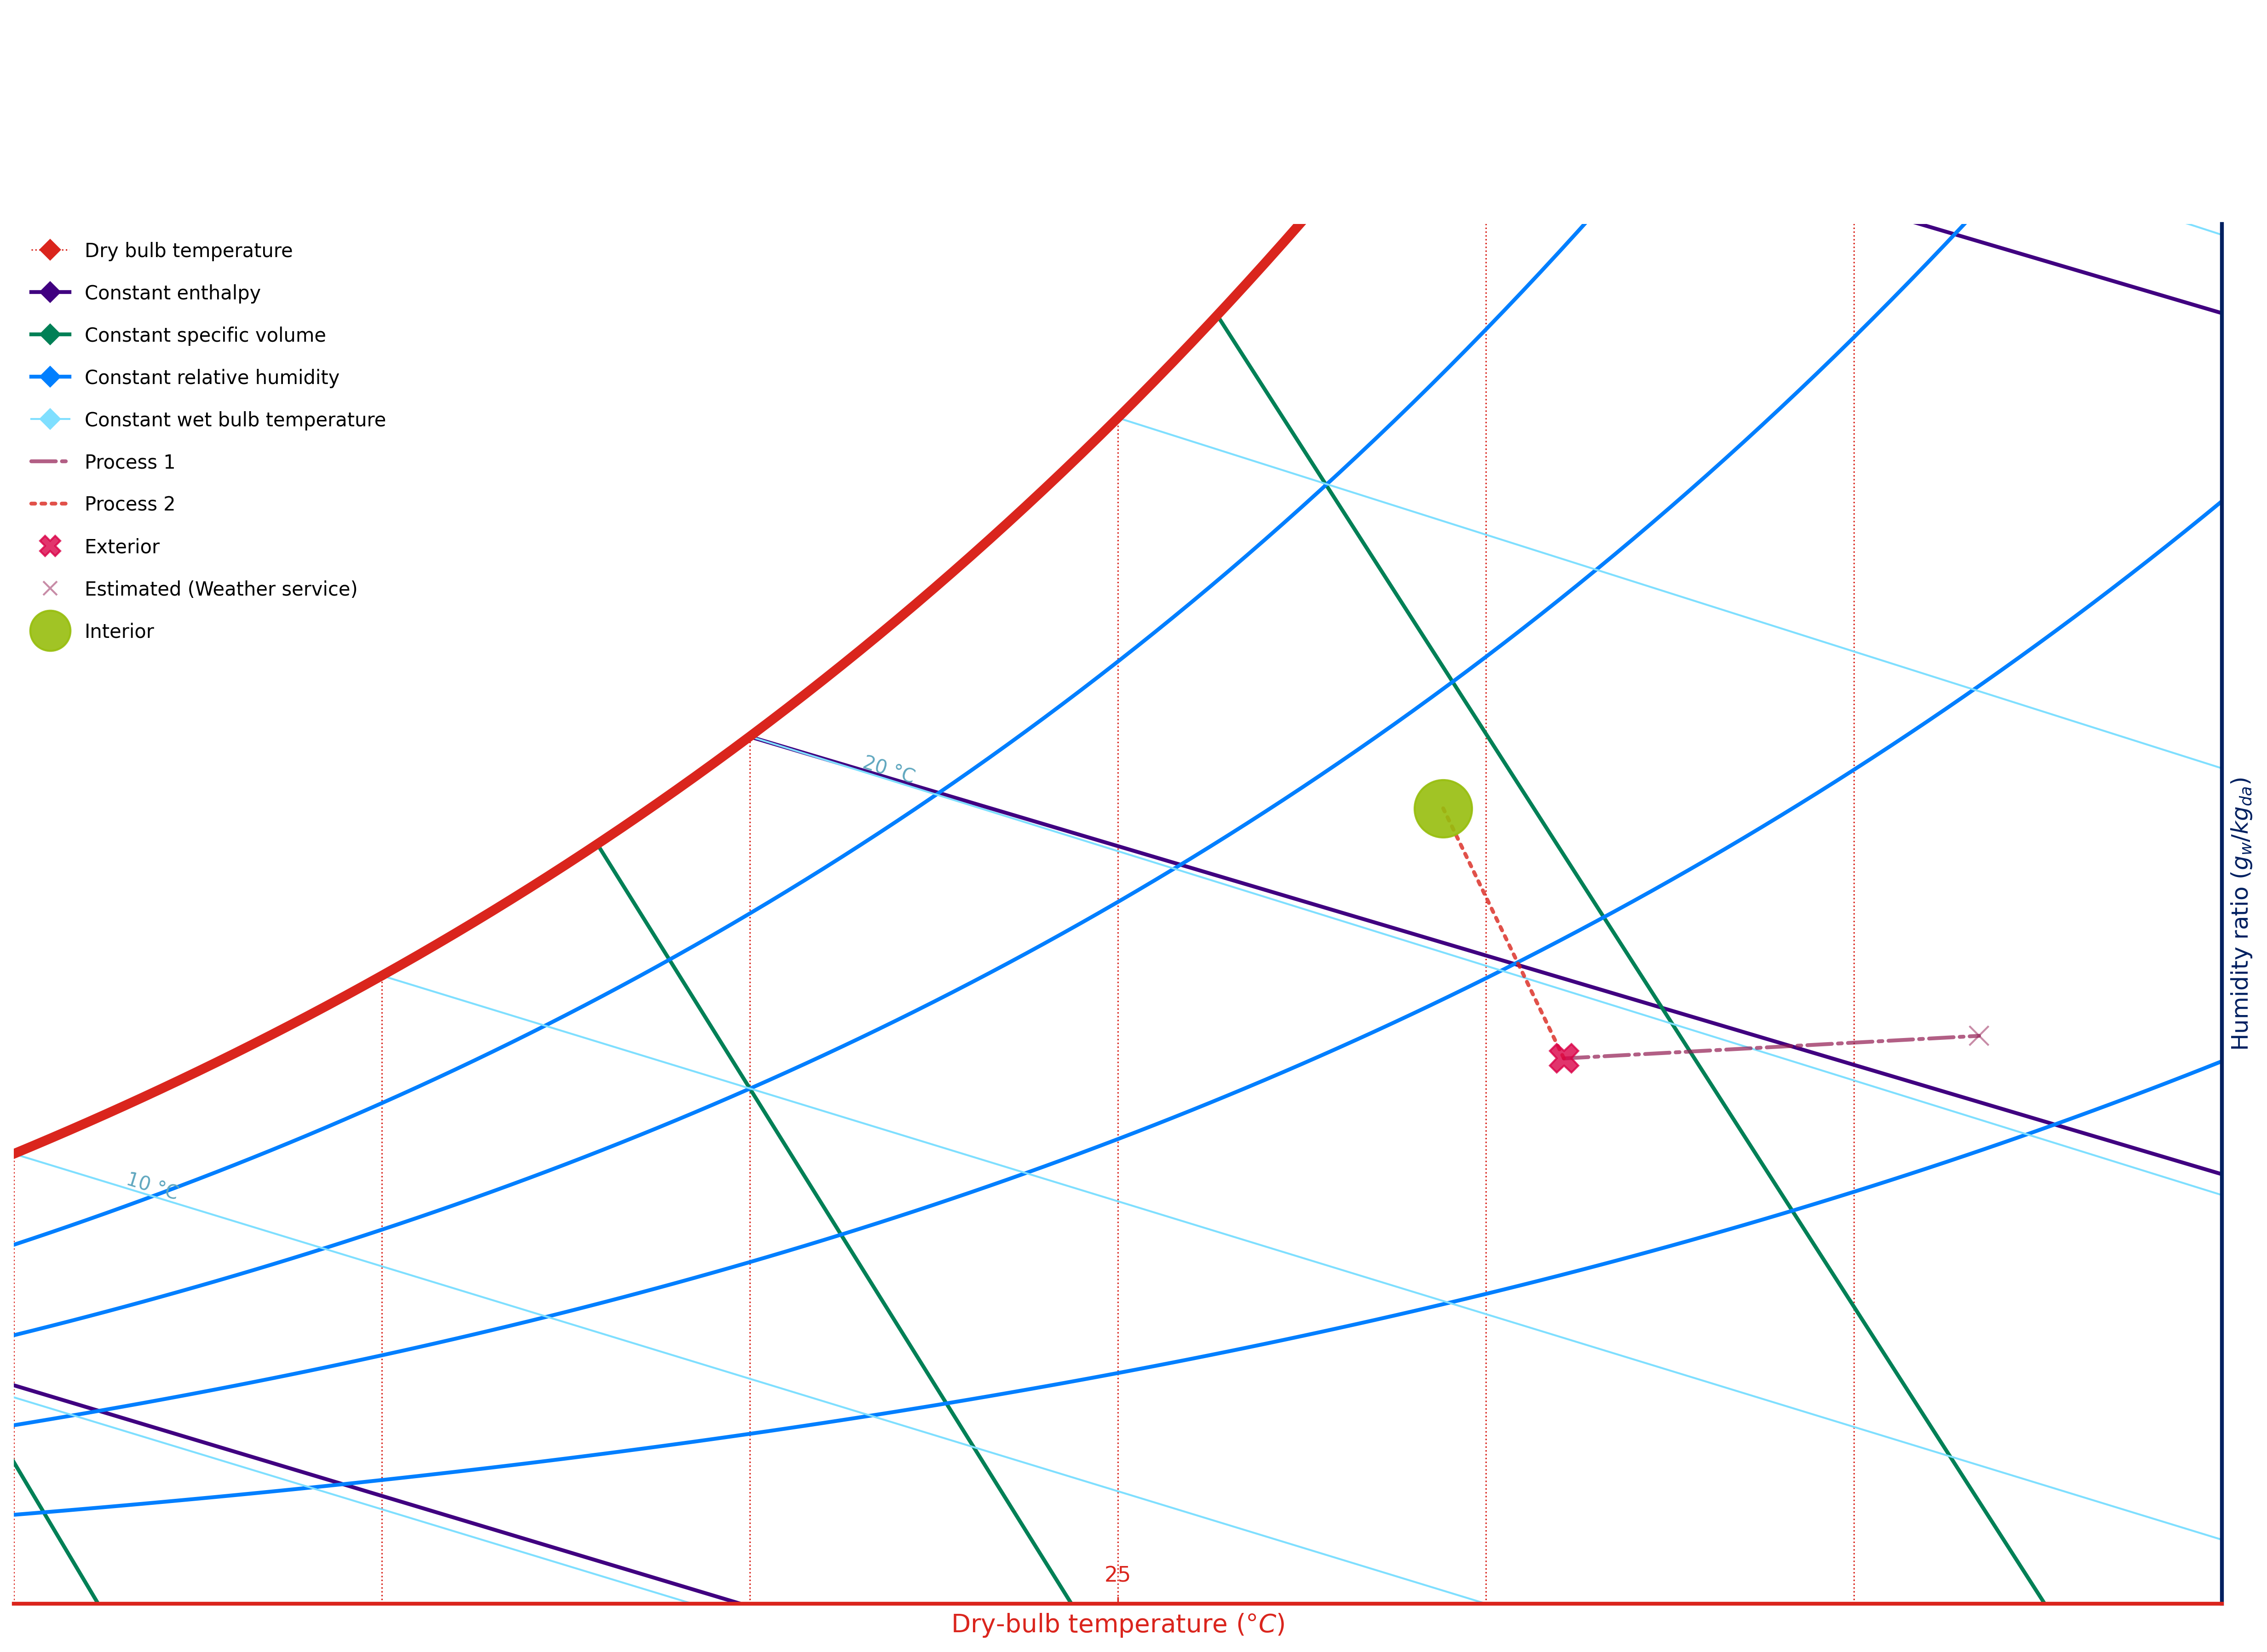

In [19]:
# Get a preconfigured chart
chart = PsychroChart(config_minimal, use_line_highlight=False)

# important, after the chart configuration, needs to be firstly initialized once by chart.plot() 
ax = chart.plot()

# Add labelled points and conexions between points
points = {'exterior': {'label': 'Exterior',
                       'style': {'color': [0.855, 0.004, 0.278, 0.8],
                                 'marker': 'X', 'markersize': 15},
                       'xy': (31.06, 32.9)},
          'exterior_estimated': {
              'label': 'Estimated (Weather service)',
              'style': {'color': [0.573, 0.106, 0.318, 0.5],
                        'marker': 'x', 'markersize': 10},
              'xy': (36.7, 25.0)},
          'interior': {'label': 'Interior',
                       'style': {'color': [0.592, 0.745, 0.051, 0.9],
                                 'marker': 'o', 'markersize': 30},
                       'xy': (29.42, 52.34)}}
connectors = [{'start': 'exterior',
               'end': 'exterior_estimated',
               'label': 'Process 1',
               'style': {'color': [0.573, 0.106, 0.318, 0.7],
                         "linewidth": 2, "linestyle": "-."}},
              {'start': 'exterior',
               'end': 'interior',
               'label': 'Process 2',
               'style': {'color': [0.855, 0.145, 0.114, 0.8],
                         "linewidth": 2, "linestyle": ":"}}]

chart.plot_points_dbt_rh(points, connectors)

# Add a legend
chart.plot_legend(markerscale=.7, frameon=False, fontsize=10, labelspacing=1.2)

# plot
ax.get_figure()